
--- Running Base Model: SVD + SVM ---
Base Model Accuracy: 0.8372


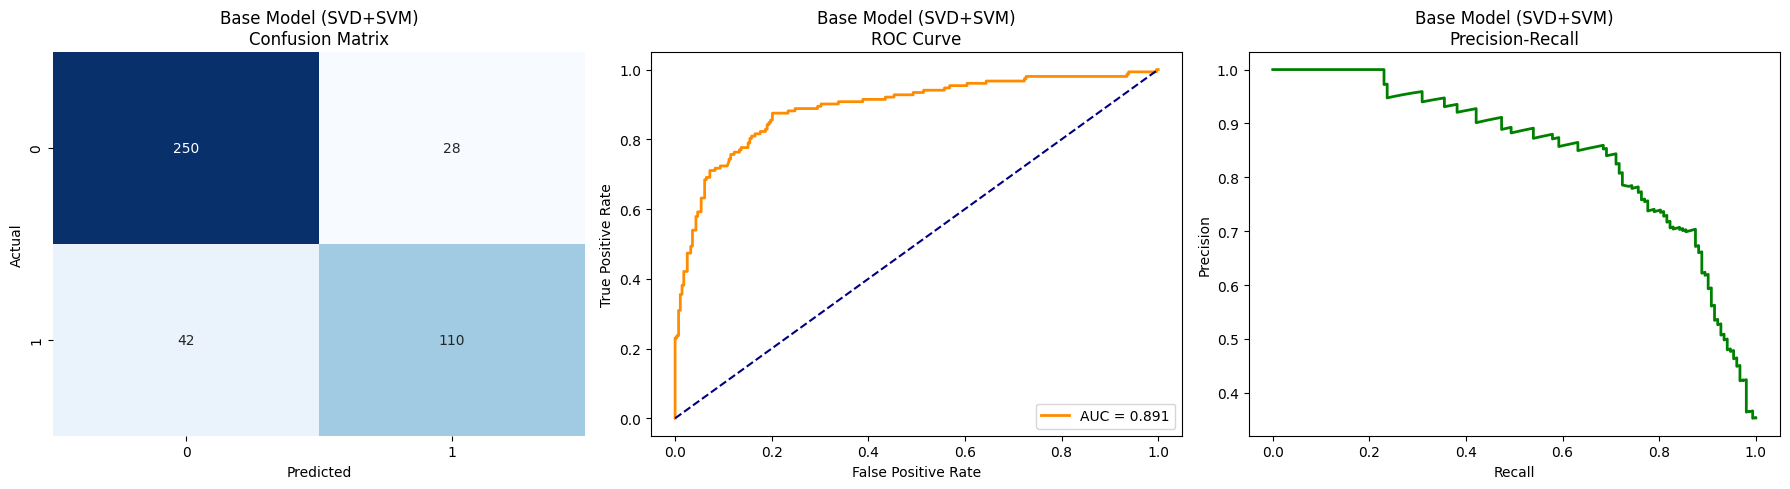


--- Running Unit 1: Optimization ---
U1 Optimization Accuracy: 0.8349


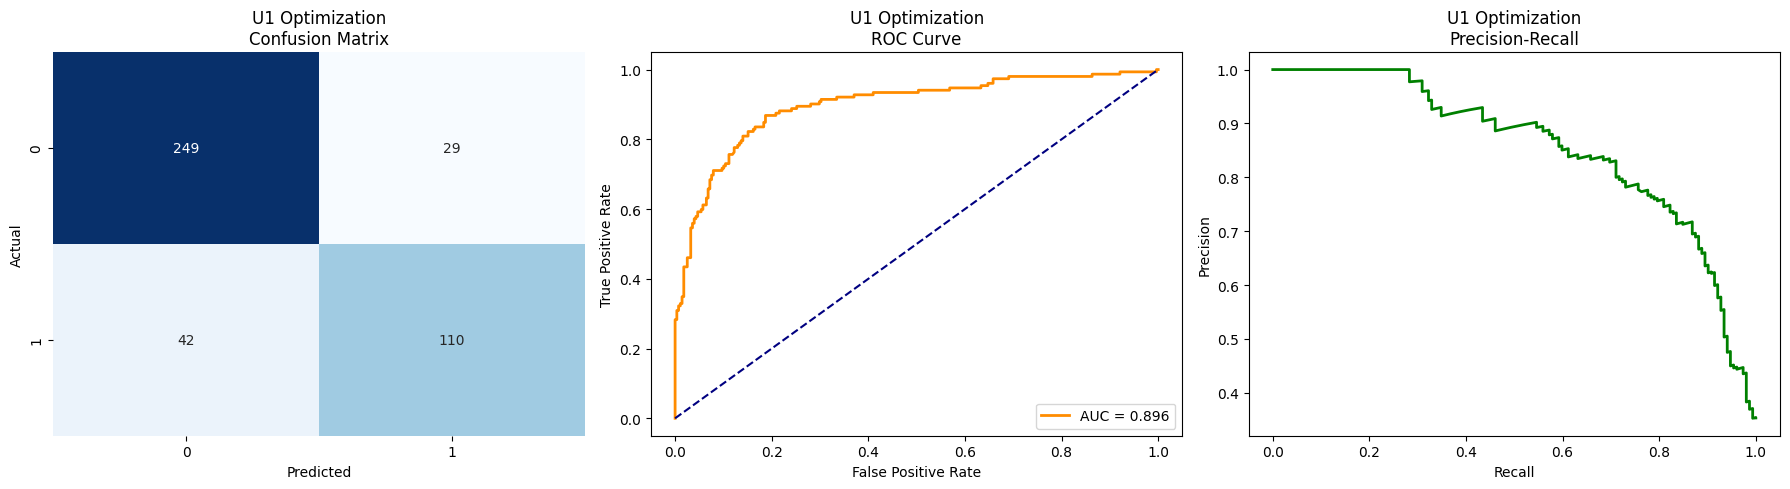


--- Running Unit 2: Preprocessing & Decomposition ---
U2 PDE Accuracy: 0.6907


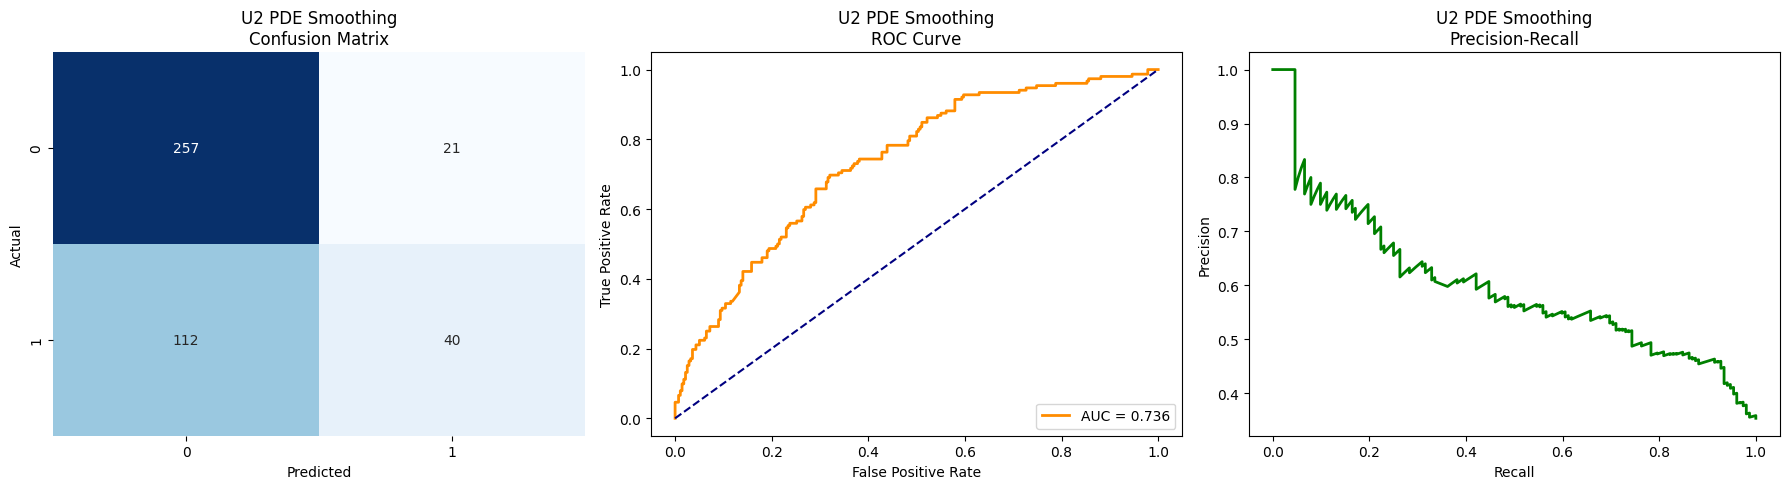

U2 Fourier Accuracy: 0.8581


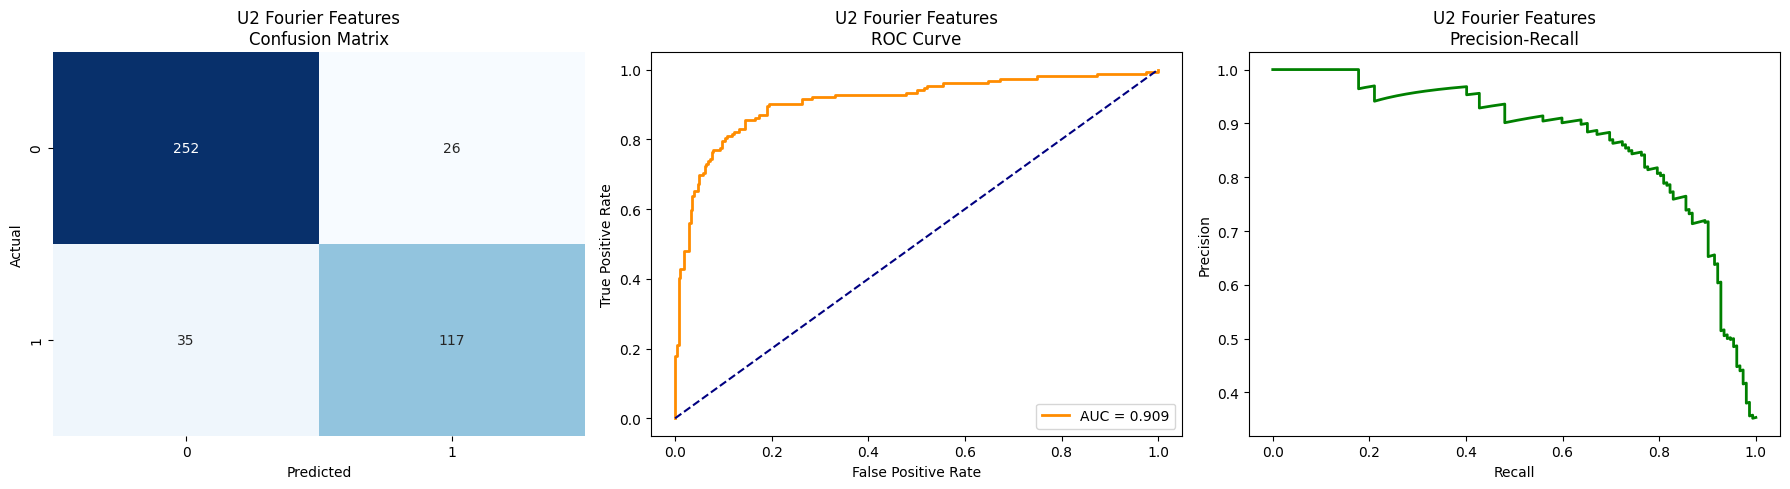

U2 DMD Accuracy: 0.5279


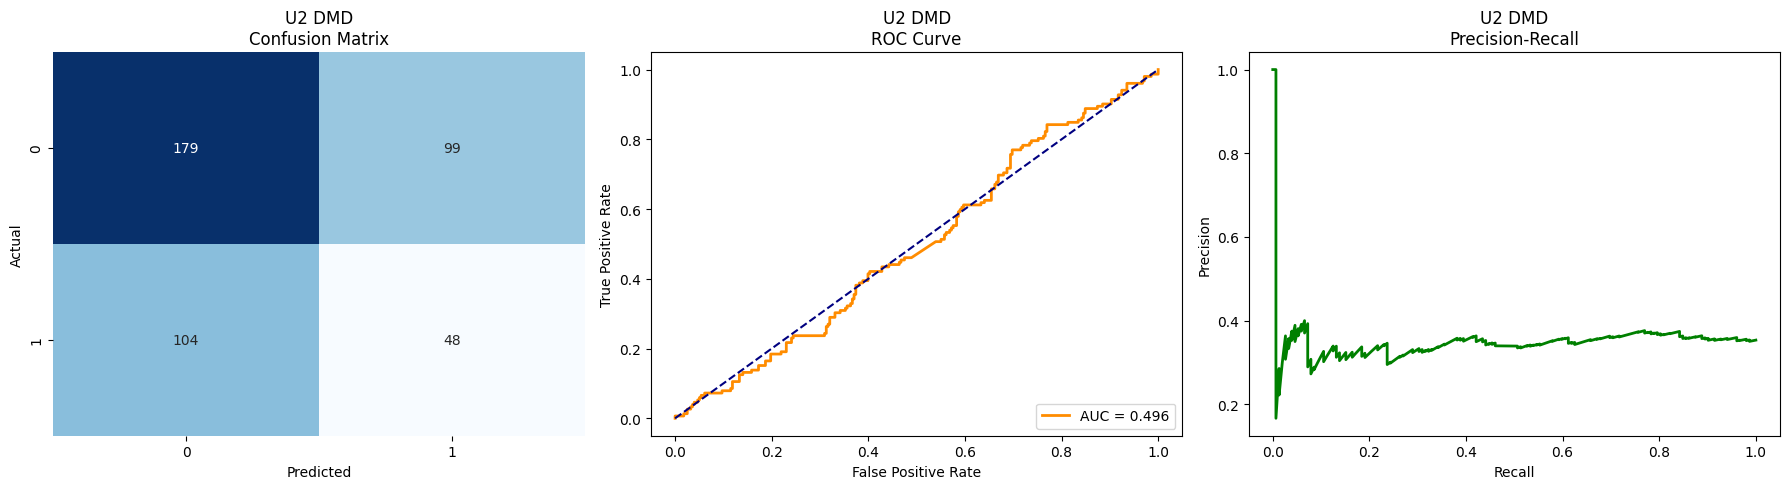

U2 HoSVD Accuracy: 0.7953


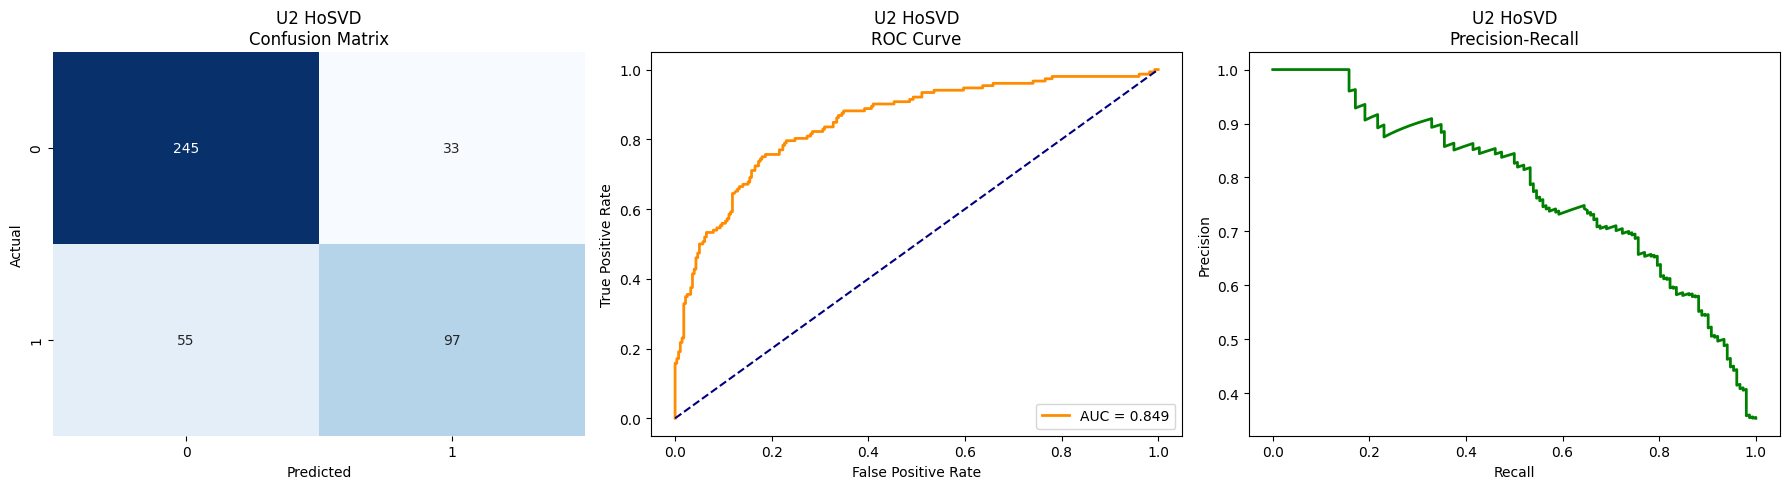


--- Running Unit 3: Advanced Training ---
U3 WLS Accuracy: 0.8093


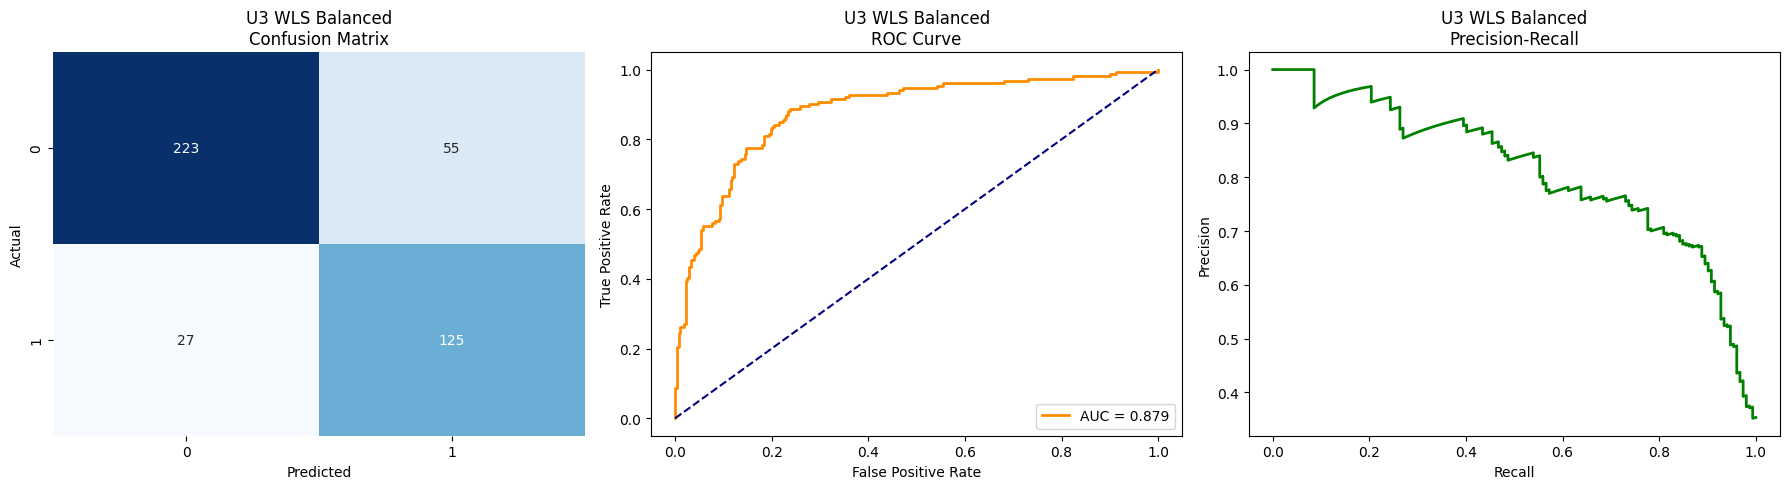

U3 Gaussian Accuracy: 0.8349


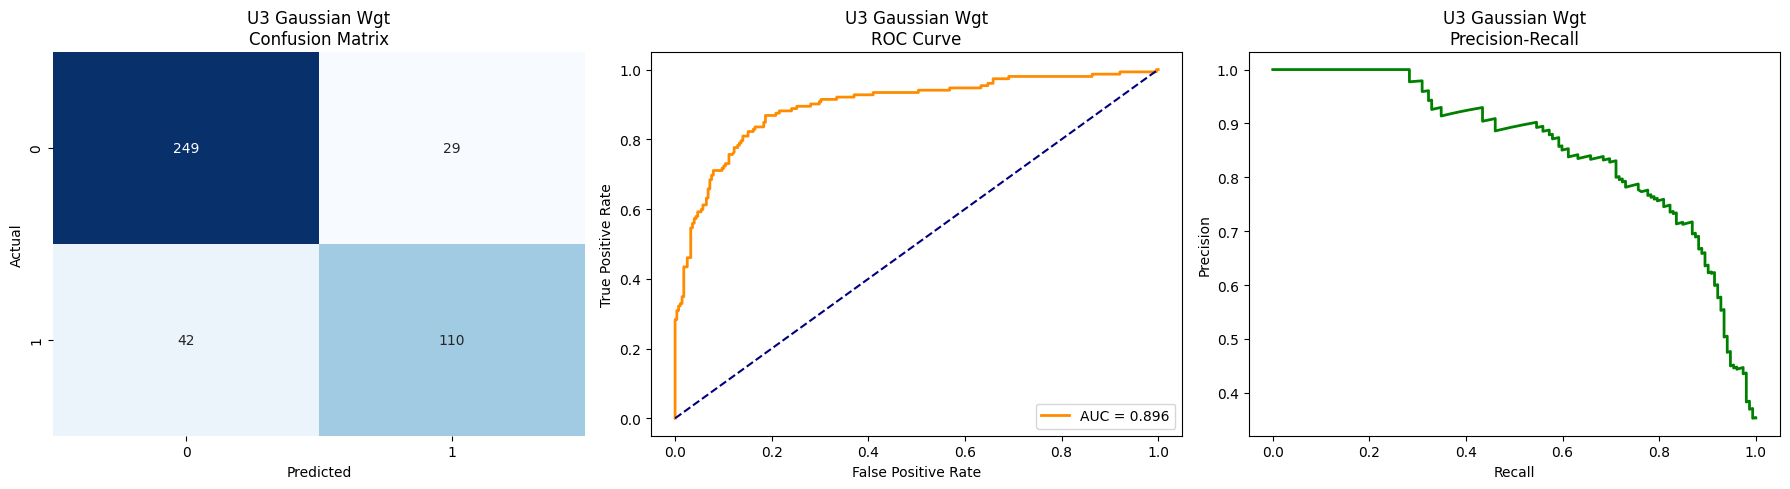

U3 Markov Accuracy: 0.8326


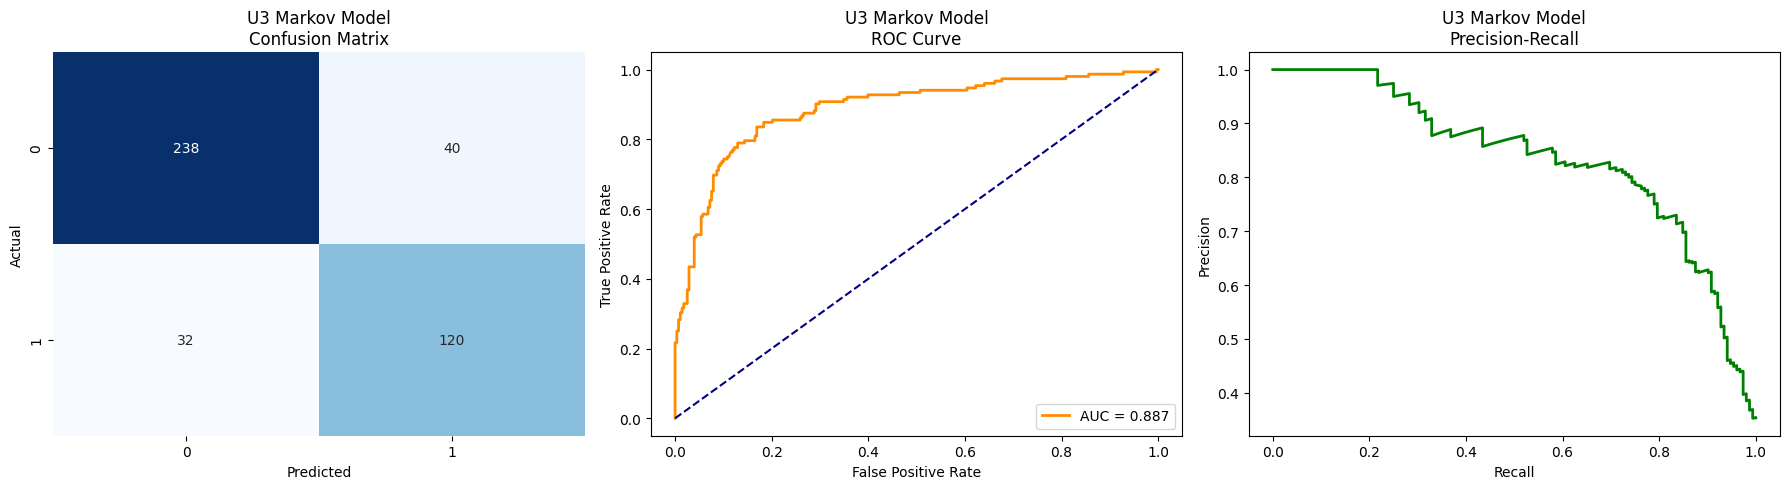

U3 MDP Accuracy: 0.8395


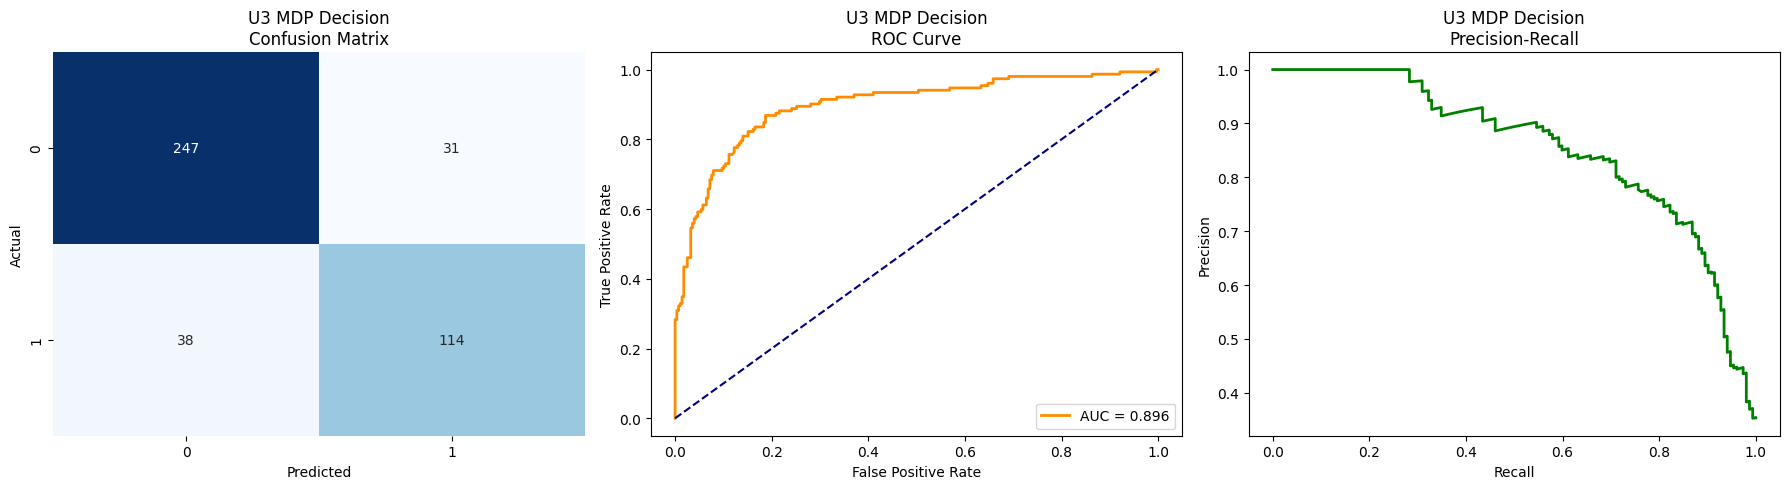


--- Running Member 3 Task: Standard Model Comparison ---
Standard Logistic Reg Accuracy: 0.8163
Standard Random Forest Accuracy: 0.9372

FINAL COMPREHENSIVE RESULTS TABLE
                         Accuracy  F1-Score    Recall  Precision       AUC
Standard: Random Forest  0.937209  0.908475  0.881579   0.937063  0.939074
U2: Fourier Feats        0.858140  0.793220  0.769737   0.818182  0.909149
U3: Markov Model         0.832558  0.769231  0.789474   0.750000  0.886643
U3: MDP Decision         0.839535  0.767677  0.750000   0.786207  0.896287
Base Model (SVD)         0.837209  0.758621  0.723684   0.797101  0.891305
U1: Optimization         0.834884  0.756014  0.723684   0.791367  0.896287
U3: Gaussian Wgt         0.834884  0.756014  0.723684   0.791367  0.896287
U3: WLS (Balanced)       0.809302  0.753012  0.822368   0.694444  0.879354
Standard: Logistic Reg   0.816279  0.739274  0.736842   0.741722  0.885365
U2: HoSVD                0.795349  0.687943  0.638158   0.746154  0.849240
U2:

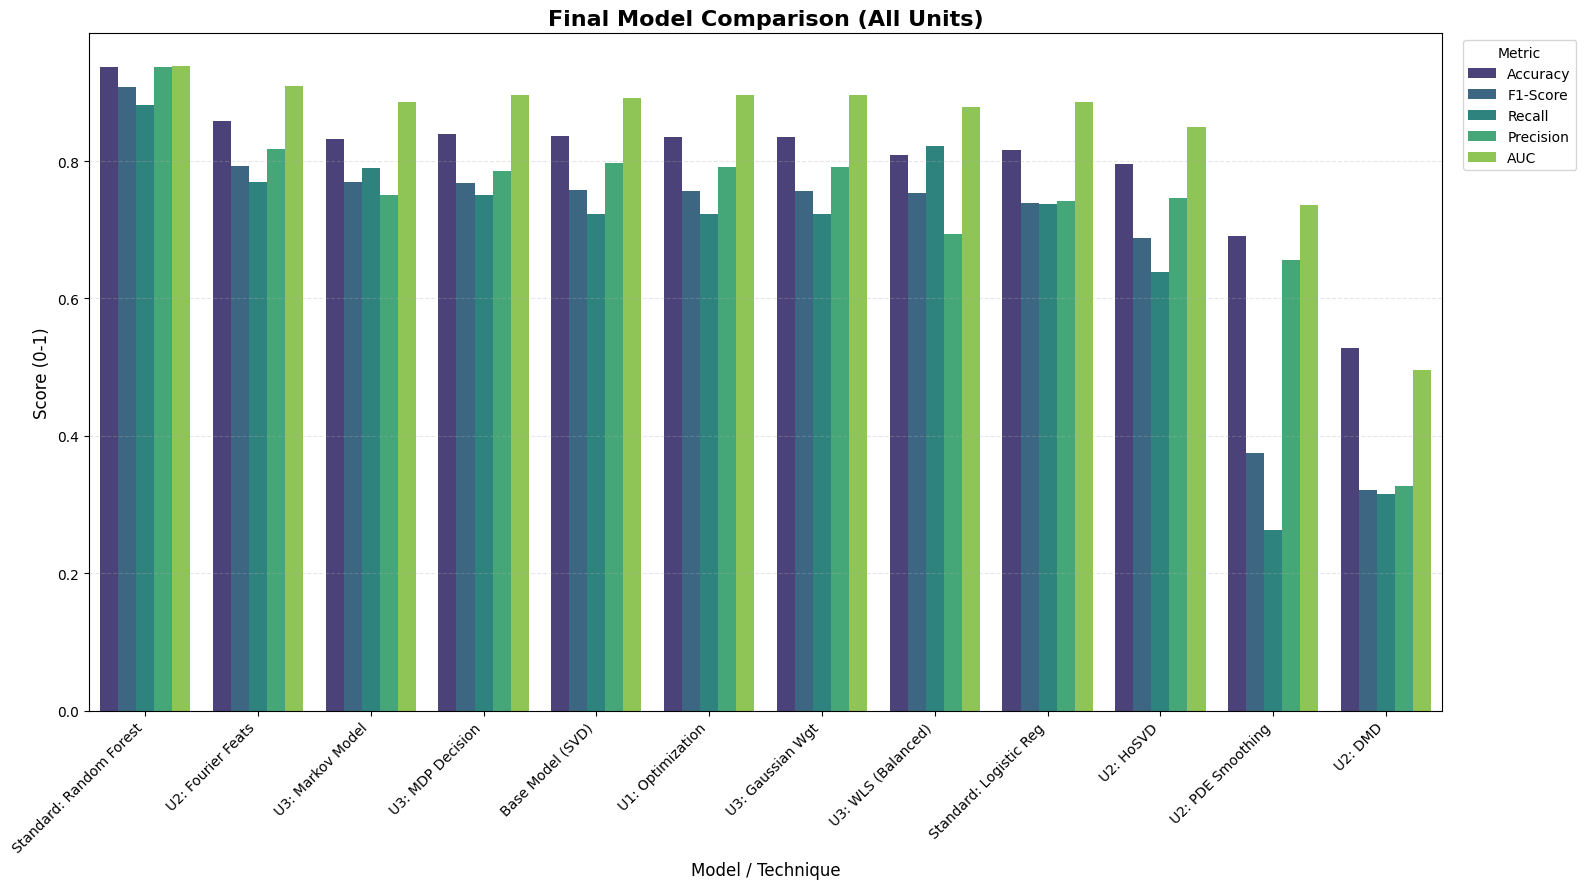


WINNER: The best performing model is 'Standard: Random Forest'
Metrics: {'Accuracy': 0.9372093023255814, 'F1-Score': 0.9084745762711864, 'Recall': 0.881578947368421, 'Precision': 0.9370629370629371, 'AUC': 0.9390737410071943}


In [2]:
# =============================================================================
# ALZHEIMER'S DISEASE CLASSIFICATION - COMPLETE SUITE WITH ACCURACY & BASE MODEL
# =============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             roc_curve, auc, precision_recall_curve,
                             recall_score, precision_score, roc_auc_score)
from sklearn.utils import resample
from scipy.ndimage import gaussian_filter1d
from scipy.stats import multivariate_normal
from scipy.linalg import svd
import warnings

warnings.filterwarnings("ignore")

# -------------------------- 0. Data Loading & Helper Functions --------------------------

# Load Dataset
try:
    df = pd.read_csv('alzheimers_disease_data.csv')
    # Drop IDs if they exist
    cols_to_drop = [c for c in ['PatientID', 'DoctorInCharge'] if c in df.columns]
    df = df.drop(cols_to_drop, axis=1)
except FileNotFoundError:
    print("Dataset not found. Generating dummy data for demonstration.")
    from sklearn.datasets import make_classification
    X_dummy, y_dummy = make_classification(n_samples=500, n_features=40,
                                           n_informative=25, n_redundant=5,
                                           random_state=42, weights=[0.6, 0.4])
    df = pd.DataFrame(X_dummy, columns=[f'feat_{i}' for i in range(40)])
    df['Diagnosis'] = y_dummy

X = df.drop('Diagnosis', axis=1)
y = df['Diagnosis']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

results = {}

def get_metrics(y_true, y_pred, y_prob):
    """Calculate Accuracy, F1, Recall, Precision, and AUC."""
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    try:
        roc_auc = roc_auc_score(y_true, y_prob)
    except:
        roc_auc = 0.5
    return [acc, f1, rec, prec, roc_auc]

def plot_model_performance(y_true, y_pred, y_prob, model_name):
    """Plots Confusion Matrix, ROC, and Precision-Recall Curves."""
    fig = plt.figure(figsize=(18, 5))

    # 1. Confusion Matrix
    plt.subplot(1, 3, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name}\nConfusion Matrix')
    plt.xlabel('Predicted'); plt.ylabel('Actual')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title(f'{model_name}\nROC Curve')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, color='green', lw=2)
    plt.title(f'{model_name}\nPrecision-Recall')
    plt.xlabel('Recall'); plt.ylabel('Precision')

    plt.tight_layout()
    plt.show()

# =============================================================================
# BASE MODEL: SVD + SVM
# =============================================================================
print("\n--- Running Base Model: SVD + SVM ---")
svd_base = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd_base.fit_transform(X_train_scaled)
X_test_svd = svd_base.transform(X_test_scaled)

svm_base = SVC(probability=True, random_state=42)
svm_base.fit(X_train_svd, y_train)

y_pred_base = svm_base.predict(X_test_svd)
y_prob_base = svm_base.predict_proba(X_test_svd)[:, 1]

results['Base Model (SVD)'] = get_metrics(y_test, y_pred_base, y_prob_base)
# Explicitly printing Accuracy as requested
print(f"Base Model Accuracy: {results['Base Model (SVD)'][0]:.4f}")
plot_model_performance(y_test, y_pred_base, y_prob_base, "Base Model (SVD+SVM)")

# =============================================================================
# UNIT 1: OPTIMIZATION
# =============================================================================
print("\n--- Running Unit 1: Optimization ---")
# GridSearch for Hyperparameter Optimization
param_grid = {'C': [0.1, 1, 10], 'kernel':['rbf'], 'gamma': ['scale']}
opt_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
opt_svm.fit(X_train_scaled, y_train)
best_model_u1 = opt_svm.best_estimator_

y_pred_u1 = best_model_u1.predict(X_test_scaled)
y_prob_u1 = best_model_u1.predict_proba(X_test_scaled)[:, 1]

results['U1: Optimization'] = get_metrics(y_test, y_pred_u1, y_prob_u1)
print(f"U1 Optimization Accuracy: {results['U1: Optimization'][0]:.4f}")
plot_model_performance(y_test, y_pred_u1, y_prob_u1, "U1 Optimization")

# =============================================================================
# UNIT 2: PREPROCESSING & DECOMPOSITION
# =============================================================================
print("\n--- Running Unit 2: Preprocessing & Decomposition ---")

# --- 2.1 PDE Smoothing ---
X_train_pde = gaussian_filter1d(X_train_scaled, sigma=1.5, axis=1)
X_test_pde = gaussian_filter1d(X_test_scaled, sigma=1.5, axis=1)
svm_pde = SVC(probability=True, random_state=42).fit(X_train_pde, y_train)
y_pred_pde = svm_pde.predict(X_test_pde)
y_prob_pde = svm_pde.predict_proba(X_test_pde)[:,1]

results['U2: PDE Smoothing'] = get_metrics(y_test, y_pred_pde, y_prob_pde)
print(f"U2 PDE Accuracy: {results['U2: PDE Smoothing'][0]:.4f}")
plot_model_performance(y_test, y_pred_pde, y_prob_pde, "U2 PDE Smoothing")

# --- 2.2 Fourier Features ---
X_train_fft = np.hstack([np.sin(X_train_scaled), np.cos(X_train_scaled)])
X_test_fft = np.hstack([np.sin(X_test_scaled), np.cos(X_test_scaled)])
svm_fft = SVC(probability=True, random_state=42).fit(X_train_fft, y_train)
y_pred_fft = svm_fft.predict(X_test_fft)
y_prob_fft = svm_fft.predict_proba(X_test_fft)[:,1]

results['U2: Fourier Feats'] = get_metrics(y_test, y_pred_fft, y_prob_fft)
print(f"U2 Fourier Accuracy: {results['U2: Fourier Feats'][0]:.4f}")
plot_model_performance(y_test, y_pred_fft, y_prob_fft, "U2 Fourier Features")

# --- 2.3 DMD (Dynamic Mode Decomposition) ---
def dmd_transform(X_data, r=10):
    X_mat = X_data.T
    X1 = X_mat[:, :-1]; X2 = X_mat[:, 1:]
    U, s, Vh = svd(X1, full_matrices=False)
    r = min(r, U.shape[1])
    U_r = U[:, :r]; s_r = np.diag(s[:r]); V_r = Vh[:r, :]
    Atilde = U_r.T @ X2 @ V_r.T @ np.linalg.inv(s_r)
    eigvals, eigvecs = np.linalg.eig(Atilde)
    Phi = X2 @ V_r.T @ np.linalg.inv(s_r) @ eigvecs
    return np.real((Phi.T @ X_mat).T)

try:
    X_train_dmd = dmd_transform(X_train_scaled, r=15)
    X_test_dmd = dmd_transform(X_test_scaled, r=15)
    # Truncate labels to match DMD shift
    min_len_tr = min(X_train_dmd.shape[0], y_train.shape[0])
    min_len_te = min(X_test_dmd.shape[0], y_test.shape[0])

    svm_dmd = SVC(probability=True, random_state=42).fit(X_train_dmd[:min_len_tr], y_train[:min_len_tr])
    y_pred_dmd = svm_dmd.predict(X_test_dmd[:min_len_te])
    y_prob_dmd = svm_dmd.predict_proba(X_test_dmd[:min_len_te])[:,1]

    results['U2: DMD'] = get_metrics(y_test[:min_len_te], y_pred_dmd, y_prob_dmd)
    print(f"U2 DMD Accuracy: {results['U2: DMD'][0]:.4f}")
    plot_model_performance(y_test[:min_len_te], y_pred_dmd, y_prob_dmd, "U2 DMD")
except Exception as e:
    print(f"DMD skipped: {e}")

# --- 2.4 Tensor/HoSVD ---
svd_tensor = TruncatedSVD(n_components=20, random_state=42)
X_train_hosvd = svd_tensor.fit_transform(X_train_scaled)
X_test_hosvd = svd_tensor.transform(X_test_scaled)
svm_hosvd = SVC(probability=True, random_state=42).fit(X_train_hosvd, y_train)
y_pred_hosvd = svm_hosvd.predict(X_test_hosvd)
y_prob_hosvd = svm_hosvd.predict_proba(X_test_hosvd)[:,1]

results['U2: HoSVD'] = get_metrics(y_test, y_pred_hosvd, y_prob_hosvd)
print(f"U2 HoSVD Accuracy: {results['U2: HoSVD'][0]:.4f}")
plot_model_performance(y_test, y_pred_hosvd, y_prob_hosvd, "U2 HoSVD")

# =============================================================================
# UNIT 3: ADVANCED TRAINING & DECISION
# =============================================================================
print("\n--- Running Unit 3: Advanced Training ---")

# --- 3.1 Weighted Least Squares (Balanced) ---
svm_wls = SVC(class_weight='balanced', probability=True, kernel='linear', random_state=42)
svm_wls.fit(X_train_scaled, y_train)
y_pred_wls = svm_wls.predict(X_test_scaled)
y_prob_wls = svm_wls.predict_proba(X_test_scaled)[:,1]

results['U3: WLS (Balanced)'] = get_metrics(y_test, y_pred_wls, y_prob_wls)
print(f"U3 WLS Accuracy: {results['U3: WLS (Balanced)'][0]:.4f}")
plot_model_performance(y_test, y_pred_wls, y_prob_wls, "U3 WLS Balanced")

# --- 3.2 Multivariate Gaussian Weighting ---
cov = np.cov(X_train_scaled.T) + 1e-5 * np.eye(X_train_scaled.shape[1])
mean = np.mean(X_train_scaled, axis=0)
weights = 1.0 / (multivariate_normal(mean=mean, cov=cov).pdf(X_train_scaled) + 1e-10)
weights = weights / np.max(weights)

svm_gauss = SVC(probability=True, random_state=42)
svm_gauss.fit(X_train_scaled, y_train, sample_weight=weights)
y_pred_gauss = svm_gauss.predict(X_test_scaled)
y_prob_gauss = svm_gauss.predict_proba(X_test_scaled)[:,1]

results['U3: Gaussian Wgt'] = get_metrics(y_test, y_pred_gauss, y_prob_gauss)
print(f"U3 Gaussian Accuracy: {results['U3: Gaussian Wgt'][0]:.4f}")
plot_model_performance(y_test, y_pred_gauss, y_prob_gauss, "U3 Gaussian Wgt")

# --- 3.3 Markov Upsampling ---
minority_X = X_train_scaled[y_train == 1]
majority_cnt = (y_train == 0).sum()
if len(minority_X) > 0:
    minority_up = resample(minority_X, replace=True, n_samples=majority_cnt, random_state=42)
    X_markov = np.vstack([X_train_scaled[y_train == 0], minority_up])
    y_markov = np.hstack([y_train[y_train == 0], np.ones(majority_cnt)])
else:
    X_markov, y_markov = X_train_scaled, y_train

svm_markov = SVC(probability=True, random_state=42).fit(X_markov, y_markov)
y_pred_mk = svm_markov.predict(X_test_scaled)
y_prob_mk = svm_markov.predict_proba(X_test_scaled)[:,1]

results['U3: Markov Model'] = get_metrics(y_test, y_pred_mk, y_prob_mk)
print(f"U3 Markov Accuracy: {results['U3: Markov Model'][0]:.4f}")
plot_model_performance(y_test, y_pred_mk, y_prob_mk, "U3 Markov Model")

# --- 3.4 MDP Threshold Optimization ---
# Optimizing threshold on the best Unit 1 model
y_prob_train_mdp = best_model_u1.predict_proba(X_train_scaled)[:, 1]
prec, rec, thresholds = precision_recall_curve(y_train, y_prob_train_mdp)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-10)
optimal_threshold = thresholds[np.argmax(f1_scores)]

y_prob_test_mdp = best_model_u1.predict_proba(X_test_scaled)[:, 1]
y_pred_mdp = (y_prob_test_mdp >= optimal_threshold).astype(int)

results['U3: MDP Decision'] = get_metrics(y_test, y_pred_mdp, y_prob_test_mdp)
print(f"U3 MDP Accuracy: {results['U3: MDP Decision'][0]:.4f}")
plot_model_performance(y_test, y_pred_mdp, y_prob_test_mdp, "U3 MDP Decision")
# =============================================================================
# MEMBER 3 TASK: COMPARATIVE ANALYSIS
# =============================================================================
print("\n--- Running Member 3 Task: Standard Model Comparison ---")

# --- Standard Model 1: Logistic Regression ---
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

results['Standard: Logistic Reg'] = get_metrics(y_test, y_pred_lr, y_prob_lr)
print(f"Standard Logistic Reg Accuracy: {results['Standard: Logistic Reg'][0]:.4f}")

# --- Standard Model 2: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

results['Standard: Random Forest'] = get_metrics(y_test, y_pred_rf, y_prob_rf)
print(f"Standard Random Forest Accuracy: {results['Standard: Random Forest'][0]:.4f}")
# =============================================================================
# FINAL COMPARISON
# =============================================================================

# Create Dataframe
metrics_cols = ['Accuracy', 'F1-Score', 'Recall', 'Precision', 'AUC']
df_res = pd.DataFrame(results, index=metrics_cols).T
df_res = df_res.sort_values(by='F1-Score', ascending=False)

print("\n" + "="*80)
print("FINAL COMPREHENSIVE RESULTS TABLE")
print("="*80)
print(df_res)
# ===============================
# STATISTICAL SIGNIFICANCE TESTS
# ===============================
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score

# Define models for comparison
models_cv = {
    'Base SVD': svm_base,
    'U1 Opt': best_model_u1,
    'U2 PDE': svm_pde,
    'U2 FFT': svm_fft,
    'U2 HoSVD': svm_hosvd,
    'U3 WLS': svm_wls,
    'U3 Gaussian': svm_gauss,
    'U3 Markov': svm_markov,
    'U3 MDP': best_model_u1,  # same as U1 with threshold
    'Logistic Reg': lr,
    'Random Forest': rf
}

# Map models to appropriate training features
features_map = {
    'Base SVD': X_train_svd,
    'U1 Opt': X_train_scaled,
    'U2 PDE': X_train_pde,
    'U2 FFT': X_train_fft,
    'U2 HoSVD': X_train_hosvd,
    'U3 WLS': X_train_scaled,
    'U3 Gaussian': X_train_scaled,
    'U3 Markov': X_markov,
    'U3 MDP': X_train_scaled,
    'Logistic Reg': X_train_scaled,
    'Random Forest': X_train_scaled
}

# Compute 5-fold CV scores for all models
cv_scores = {}
for name, model in models_cv.items():
    X_cv = features_map[name]
    # Use y_markov for the 'U3 Markov' model, otherwise use y_train
    if name == 'U3 Markov':
        y_cv = y_markov
    else:
        y_cv = y_train
    scores = cross_val_score(model, X_cv, y_cv, cv=5, scoring='accuracy')
    cv_scores[name] = scores

# Pairwise t-tests and p-values
print("\n--- PAIRWISE MODEL COMPARISON (t-test on Accuracy) ---")
model_names = list(models_cv.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        m1, m2 = model_names[i], model_names[j]
        t_stat, p_val = ttest_ind(cv_scores[m1], cv_scores[m2])
        print(f"{m1} vs {m2}: t = {t_stat:.4f}, p = {p_val:.4f}")

# Plotting Grouped Bar Chart
df_plot = df_res.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

plt.figure(figsize=(16, 9))
sns.barplot(data=df_plot, x='index', y='Score', hue='Metric', palette='viridis')
plt.title('Final Model Comparison (All Units)', fontsize=16, fontweight='bold')
plt.xlabel('Model / Technique', fontsize=12)
plt.ylabel('Score (0-1)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

best_model = df_res.index[0]
print(f"\nWINNER: The best performing model is '{best_model}'")
print(f"Metrics: {df_res.loc[best_model].to_dict()}")